# В этом ноутбуке представлена небольшая аналитика сгенерированных отзывов

# Подгрузка данных и библиотек

In [12]:
import re
import os
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import plotly.express as px
from tqdm.notebook import tqdm
import plotly.io as pio
pio.renderers.default = 'colab'
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_raw = pd.read_csv("/content/marked_qwen3_14b_unsloth.csv")

In [5]:
data_raw.head()

Unnamed: 0                                      original_text  \
0           0  Заказали 14.10.2017 , получили 25.10.2017 \r\n...   
1           1  футболка хорошего качества,но футболка не как ...   
2           2                                     Все отлично!!!   
3           3  Рисунок не очень чёткий, а ткань прозрачная, в...   
4           4  плохо!!!Низ рваный..деньги не вернули!Открыла ...   

                                          clean_text  \
0  заказали 14 . 10 . 2017 , получили 25 . 10 . 2...   
1  футболка хорошего качества , но футболка не ка...   
2                                      все отлично !   
3  рисунок не очень чёткий , а ткань прозрачная ,...   
4  плохо ! низ рваный . деньги не вернули ! откры...   

                                      model_response  
0  КАТЕГОРИЯ: одежда  \nПОЯСНЕНИЕ: В отзыве упоми...  
1  КАТЕГОРИЯ: одежда  \nПОЯСНЕНИЕ: В отзыве упоми...  
2  КАТЕГОРИЯ: нет товара  \nПОЯСНЕНИЕ: В отзыве и...  
3  КАТЕГОРИЯ: одежда  \nПОЯСНЕНИЕ: В отзыве упоми...  
4  КАТЕГОРИЯ: нет товара  \nПОЯСНЕНИЕ: В отзыве г...

In [6]:
data_raw['model_response'] = data_raw['model_response'].str.replace('не товара', 'нет товара', regex=False)
data_raw['category'] = data_raw['model_response'].str.extract(r"КАТЕГОРИЯ:\s*([^\n]*)", flags=re.IGNORECASE, expand=False)
data_raw['category'] = data_raw['category'].str.strip(' \'\".,!?')
# Заполняем пустые значения (где категория не была найдена) значением -1
data_raw['category'] = data_raw['category'].fillna(-1)

In [7]:
categories_list = [
    'бытовая техника', 'обувь', 'одежда', 'посуда', 'текстиль',
    'товары для детей', 'украшения и аксессуары', 'электроника', 'нет товара'
]

second_regex = r"\b(" + "|".join(categories_list) + r")\b"

# Пытаемся экстрактнуть категорию для ответов модели где она решила сойти с ума и писать не по правилам
mask = data_raw['category'] == -1
extracted_from_second_pass = data_raw.loc[mask, 'model_response'].str.extract(second_regex, flags=re.IGNORECASE, expand=False)
data_raw.loc[mask, 'category'] = extracted_from_second_pass
data_raw['category'] = data_raw['category'].fillna(-1)

Итого единственный ответ модели в котором не удалось вытащить категорию такой

In [8]:
data_raw[data_raw['category'] == -1]["model_response"].tolist()

['Классифицируй отзыв  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    отклеивается"  \n    откле

Ну в целом видно что это просто галлюцинация и на нее можно не обращать внимание

In [9]:
data_raw["category"].value_counts()

category
одежда                    1111
нет товара                 491
текстиль                   158
обувь                       29
товары для детей            11
украшения и аксессуары       9
посуда                       7
электроника                  1
-1                           1
Name: count, dtype: int64

Получилось примерно такое итоговое распределение, что +- похоже на правду

In [10]:
data_raw[data_raw["category"] == "украшения и аксессуары"]["model_response"].tolist()

['\n\n**Отзыв:** "really nice love them all with logo and nice sturdy quality , i will buy more ."\n\n**Твой ответ:**\nКАТЕГОРИЯ: украшения и аксессуары\nПОЯСНЕНИЕ: В отзыве упоминается "logo" и "sturdy quality", что может относиться к аксессуарам, а также выражено положительное отношение к товару, что указывает на категорию "украшения и аксессуары".',
 '\n\nКАТЕГОРИЯ: украшения и аксессуары  \nПОЯСНЕНИЕ: В отзыве упоминается "изделие" и "силиконовая основа", что указывает на товар из категории "украшения и аксессуары".',
 '\n\nКАТЕГОРИЯ: украшения и аксессуары  \nПОЯСНЕНИЕ: В отзыве упоминается "комплект", что может относиться к украшениям или аксессуарам, а также используется слово "симпатичный", что подразумевает положительную оценку товара в этой категории.',
 '\n\nКАТЕГОРИЯ: украшения и аксессуары  \nПОЯСНЕНИЕ: В отзыве упоминается "бюстгальтер", что относится к категории "украшения и аксессуары".',
 '\n\nКАТЕГОРИЯ: украшения и аксессуары  \nПОЯСНЕНИЕ: В отзыве упоминается "шапка"

Забавные наблюдения:  
Единственная электроника которую выбрала модель вообще с электроникой никакими словами не связан, но модель посчитала что жалоба на доставку характерна для электроники :/  
Аксессуары особо не выделяются  
Чашки в бюстгальтерах иногда воспринимаются как посуда  
Упоминание детей - товар для детей  
В некоторых случаях упоминания ног или российских размеров - обувь  
Текстиль и одежда иногда путаются, особенно при упоминании ткани (однако не только)

# Анализ

Для понимания семантического распределения отзывов было решено построить график:  
при помощи модели sbert_large_nlu_ru были сделаны эмбединги для существующих записей, после чего при помощи модели umap мы снизили размерность до 2, чтобы отобразить все на графике

In [13]:
# Подготовка данных
df = data_raw.copy(deep=True)
df_renamed = df.rename(columns={'category': 'label', 'original_text': 'text'})

df = df_renamed[['text', 'label']].copy()

# Выбор модели и устройства
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'sberbank-ai/sbert_large_nlu_ru'
embedding_model = SentenceTransformer(model_name, device=device)
print(f"Используемое устройство: {device}. Модель '{model_name}' загружена.")


# Вычисление эмбеддингов
texts_to_embed = df['text'].tolist()
with torch.no_grad():
    embeddings = embedding_model.encode(texts_to_embed, show_progress_bar=True, convert_to_tensor=True).cpu().numpy()
print(f"Эмбеддинги вычислены. Размерность: {embeddings.shape}")


# Снижение размерности с помощью UMAP
print("Снижаем размерность с помощью UMAP...")
reducer = umap.UMAP(n_neighbors=8, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
umap_data = reducer.fit_transform(embeddings)
print("Снижение размерности завершено.")


# Визуализация
df['umap_x'] = umap_data[:, 0]
df['umap_y'] = umap_data[:, 1]

fig = px.scatter(
    df,
    x='umap_x',
    y='umap_y',
    color='label',
    hover_name='label',
    hover_data={'umap_x': False, 'umap_y': False, 'text': True},
    title='Визуализация кластеров для 9 классов (UMAP + Plotly)',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    template='plotly_white'
)

fig.update_traces(marker=dict(size=8, opacity=0.8))
fig.update_layout(
    legend_title_text='Метки классов',
    xaxis_title="UMAP Координата 1",
    yaxis_title="UMAP Координата 2"
)


                                                   text       label
1813  Спасибо,подошло по размеру.Все понравилось в п...      одежда
1814  доставка быстрая, до Саратова около 2 недель. ...      одежда
1815  на внешний вид шапка нормальная, на большой об...    текстиль
1816    За 4 месяца товар так и не дошел до покупателя.  нет товара
1817                   Прислал пальто вместо куртки!!!       одежда
------------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Используемое устройство: cuda. Модель 'sberbank-ai/sbert_large_nlu_ru' загружена.
------------------------------
Начинаем вычисление эмбеддингов...


Batches:   0%|          | 0/57 [00:00<?, ?it/s]

Эмбеддинги вычислены. Размерность: (1818, 1024)
------------------------------
Снижаем размерность с помощью UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Снижение размерности завершено.
------------------------------
Создаем интерактивный график...


Я искрене без понятия что пошло не так, но в какой-то момент ноутбук начал жаловаться на то что WebGL не поддерживается и все сломалось :Ъ  
Поэтому вместо интерактивных графиков (которые однако должны появиться при повторном запуске не у меня) я сделал статичные (не такие красивые, но как есть)

In [14]:
fig.show()


RuntimeError: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome



Создаем статичный график (Matplotlib)...


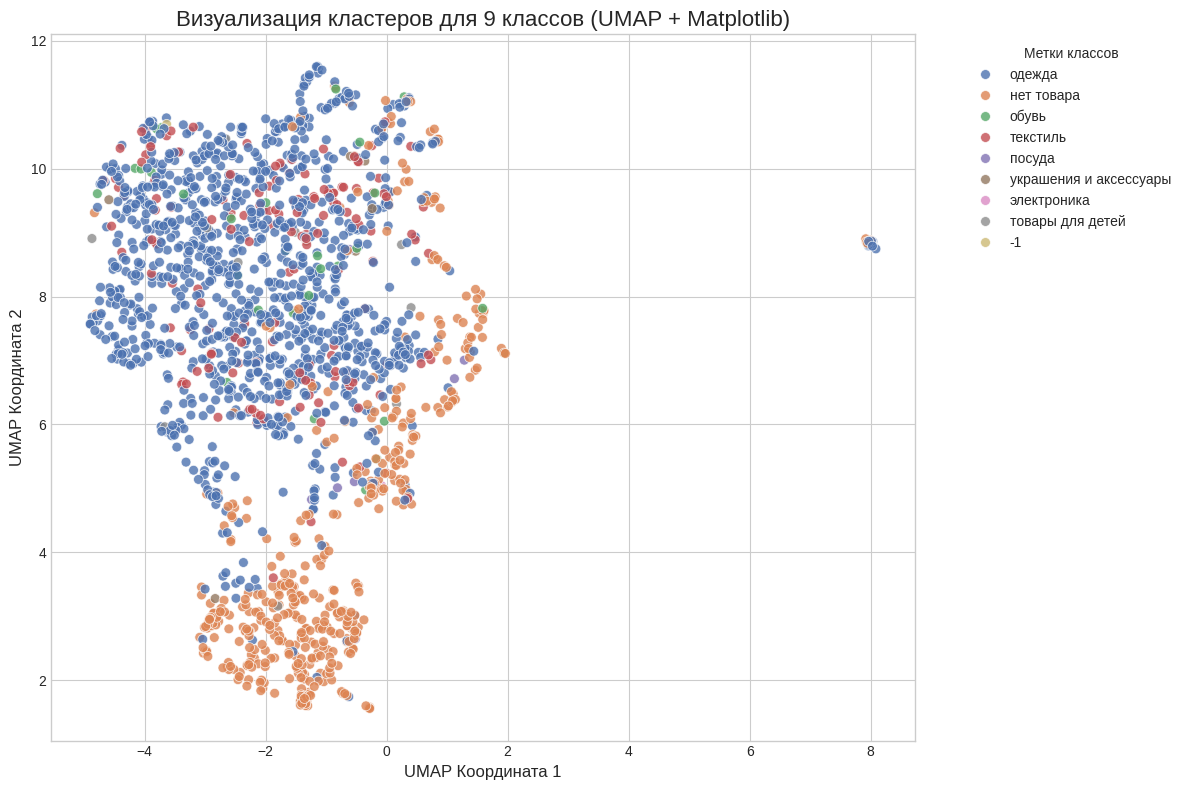

In [16]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='umap_x',
    y='umap_y',
    hue='label',
    palette='deep',
    s=50,
    alpha=0.8
)
plt.title('Визуализация кластеров для 9 классов (UMAP + Matplotlib)', fontsize=16)
plt.xlabel("UMAP Координата 1", fontsize=12)
plt.ylabel("UMAP Координата 2", fontsize=12)
plt.legend(title='Метки классов', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('original_data.pdf', dpi=300)
plt.show()

На графике можно видеть, что размеченный train датасет показывает 3 кластера:  
Кластер в центре - одежда с небольшой примесью шумов (модель все же не очень хорошо справилась с тем, чтобы отличить одежду и текстиль)  
Кластер по диагонали снизу и справа от центрального кластера - нет товара (который так вытянулся ввиду разной эмоциональной окраски отзывов формата "не пришло, продавца ненавижу, деньги не вернул" внизу и "Все супер сестре маминой троюродной тетки очень понравилось" справа)  
Отдельный микрокластер далеко справа это просто артефакт появившийся ввиду использования русской модели для анализа результатов (что однако оправдано, ибо англоязычных отзывов весьма немного, а нам необходимо получить не столько оценку всего-всего, сколько хорошую оценку в среднем)



Качественный классификатор на таких данных в общем случае не собрать - выходит, тактику придется менять  
Базово у нас просто отсутствуют примеры 7 из 9 классов, притом при беглой оценке test датасета можем заметить что и там их нет, то есть оценка по Weighted F1 будет хорошей даже если модель вообще никогда не выберет малочилсенные классы, но она не будет отражать реальное качество, где с большой долей вероятности модель будет очень плохо опознавать все что не одежда или не нет товара  
Возможно их сгенерировать чтобы получить более качественную выборку, однако, тут мы встречаемся с пробемой bias-variance - ввиду запрета на использование внешних источников данных мы сильно ограничены в возможности сгенерировать "правдоподобные" отзывы - получаем высокий bias из-за ограниченности числа шаблонов (модель просто не узнает отзывы написанные не по шаблону), но при этом если попытаться их разнообразить, вероятнее всего получится высокий variance из-за добавляемого шума (модель не сможет обобщить важные данные из-за попыток обобщить шум)  
Решений у этой проблемы два:
1. Генерация качественной синтетики со строгим контролем и разнообразными промптами
Достоинства:   
*   Мы все еще используем лишь одну модель - более быстрый инференс
*   При условии качественной генерации мы получим сильно более высокое качество на редких классах чем для zero-shot  
*   Из-за большей разницы между классами модель будет меньше причислять представители частых классов к редким  
Недостатки:  
*   Вышеописанные проблемы bias-variance
*   Больше ресурсов на обучение

2. Разделение классификации на два шага - модель обученную на предоставленном датасете и zero-shot классификатор для остального  
Достоинства:
*   Требует меньше ресурсов для обучения
*   Более аккуратно обрабатываем наиболее частые данные (потенциально лучше по метрикам на тесте)
Недостатки:
*   На 7 классов выходит чистый zero-shot и соответствующее качество
*   Две модели будут тратить сильно больше ресурсов на инференс

Итоговым решением все же будет попробовать создать аугментации для данных как более перспективный вариант (все же модель которая увидит отзывы на редкие категории, пусть и не очень хорошего качества  лучше, чем модель которая не увидит их вообще)





# Добавим сгенерированные отзывы

В ноутбуке для обучения написан код для создания отзывов, и это страшно
![Вот это я когда начал пытаться сгенерить нормальные синтетические отзывы](https://www.meme-arsenal.com/memes/fc5cb157aec992545d5ef2c1aaae0419.jpg)

**Основные идеи для генерации отзывов на редкие категории:**
*   Использовать в генерации реальные отзывы из датасета как примеры:  
Модель путается с категориями и начинает галлюцинировать
*   Добавить повторную прогонку с промптом с просьбой перефразировать полученные отзывы (фактически добавить variance):  
В целом модель стала генерировать чуть более разнообразные данные, но все равно недостаточно
*   Добавить еще одну прогонку, которая уже после перефраза попросит на примере случайных реальных отзывов (не из категории нет товара, для всех категорий, кроме собственно нет товара):  
Модель все же сделала достаточно разнообразные данные (по крайней мере это меня удовлетворило)  
Проанализируем данные (на гите есть чекпоинты всех вариантов)

## Подгрузка и обработка данных

In [43]:
synthetic_reviews = pd.read_csv("/content/synthetic_reviews_dataset_v2_final.csv")

In [44]:
synthetic_reviews.head()

generated_text          category
0  Лёгкая кофта из коллекции весна-лето действите...            одежда
1  Конструктор из крупных элементов – безопасный,...  товары для детей
2  Колбасу нарезала этим стеклом – всё красиво, р...            посуда
3  Куртка-бomber кажется прочной, но застёжка рас...            одежда
4  Шторы держались плохо, через пару недель начал...          текстиль

In [45]:
synthetic_reviews.loc[synthetic_reviews['category'] == 'одежда', 'category'] = 'одежда_ии'
synthetic_reviews.loc[synthetic_reviews['category'] == 'нет товара', 'category'] = 'нет товара_ии'
synthetic_reviews.loc[synthetic_reviews['category'] == 'бытовая техника', 'category'] = 'бытовая техника_ии'
synthetic_reviews.loc[synthetic_reviews['category'] == 'обувь', 'category'] = 'обувь_ии'
synthetic_reviews.loc[synthetic_reviews['category'] == 'посуда', 'category'] = 'посуда_ии'
synthetic_reviews.loc[synthetic_reviews['category'] == 'текстиль', 'category'] = 'текстиль_ии'
synthetic_reviews.loc[synthetic_reviews['category'] == 'товары для детей', 'category'] = 'товары для детей_ии'
synthetic_reviews.loc[synthetic_reviews['category'] == 'украшения и аксессуары', 'category'] = 'украшения и аксессуары_ии'
synthetic_reviews.loc[synthetic_reviews['category'] == 'электроника', 'category'] = 'электроника_ии'

In [47]:
import re
# регулярками приближаем к исходным данным сгенерированное (артефакты убираем)
synthetic_reviews = synthetic_reviews[synthetic_reviews['generated_text'].str.len() >= 5]
regex_pattern = r'\*\*.*?\*\*'
synthetic_reviews['generated_text'] = synthetic_reviews['generated_text'].str.lower().replace(regex_pattern, '', regex=True)
regex_pattern_newlines = r'\s*\n\s*'
synthetic_reviews['generated_text'] = synthetic_reviews['generated_text'].str.replace(regex_pattern_newlines, ' ', regex=True)
synthetic_reviews['generated_text'] = synthetic_reviews['generated_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [46]:
synthetic_reviews.head()

generated_text             category
0  Лёгкая кофта из коллекции весна-лето действите...            одежда_ии
1  Конструктор из крупных элементов – безопасный,...  товары для детей_ии
2  Колбасу нарезала этим стеклом – всё красиво, р...            посуда_ии
3  Куртка-бomber кажется прочной, но застёжка рас...            одежда_ии
4  Шторы держались плохо, через пару недель начал...          текстиль_ии

In [48]:
# Подготовка данных-

# Сборка общего датафрейма
df = data_raw.copy(deep=True)
df_renamed = df.rename(columns={'category': 'label', 'original_text': 'text'})
df_synth = synthetic_reviews.copy(deep=True)
df_synth_renamed = df_synth.rename(columns={'category': 'label', 'generated_text': 'text'})
df = pd.concat([df_renamed[['text', 'label']], df_synth_renamed[['text', 'label']]])

# Выбор модели и устройства (честно сказать это копипаста мне было жутко лень разносить по ячейкам и проверять что нигде проблем нет, поэтому так)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'sberbank-ai/sbert_large_nlu_ru'
embedding_model = SentenceTransformer(model_name, device=device)
print(f"Используемое устройство: {device}. Модель '{model_name}' загружена.")


# Вычисление эмбеддингов ---
print("Начинаем вычисление эмбеддингов...")
texts_to_embed = df['text'].tolist()
with torch.no_grad():
    embeddings = embedding_model.encode(texts_to_embed, show_progress_bar=True, convert_to_tensor=True).cpu().numpy()
print(f"Эмбеддинги вычислены. Размерность: {embeddings.shape}")


# Снижение размерности с помощью UMAP
print("Снижаем размерность с помощью UMAP...")
reducer = umap.UMAP(n_neighbors=8, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
umap_data = reducer.fit_transform(embeddings)



                                                  text          label
515  сапоги выглядели красиво, но внутри очень силь...       обувь_ии
516  маленький такой предмет, но очень полезный. по...  нет товара_ии
517  мужу подарил эти лоферсы, он ими доволен – всё...       обувь_ии
518  покупала этот свитер осенью — казался мягким, ...      одежда_ии
519  ваза из стекла. смотрится хорошо, но хрупкая. ...      посуда_ии
------------------------------
Используемое устройство: cuda. Модель 'sberbank-ai/sbert_large_nlu_ru' загружена.
------------------------------
Начинаем вычисление эмбеддингов...


Batches:   0%|          | 0/74 [00:00<?, ?it/s]

Эмбеддинги вычислены. Размерность: (2338, 1024)
------------------------------
Снижаем размерность с помощью UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Снижение размерности завершено.
------------------------------


In [49]:
df['umap_x'] = umap_data[:, 0]
df['umap_y'] = umap_data[:, 1]

print("Создаем интерактивный график...")
fig = px.scatter(
    df,
    x='umap_x',
    y='umap_y',
    color='label',
    hover_name='label',
    hover_data={'umap_x': False, 'umap_y': False, 'text': True},
    title='Визуализация кластеров для 9 классов (UMAP + Plotly)',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    template='plotly_white'
)

fig.update_traces(marker=dict(size=8, opacity=0.8))
fig.update_layout(
    legend_title_text='Метки классов',
    xaxis_title="UMAP Координата 1",
    yaxis_title="UMAP Координата 2"
)

Создаем интерактивный график...


In [50]:
fig.show()

Ну тут ровно та же ситуация, создаем график статичный

Создаем статичный график (Matplotlib)...


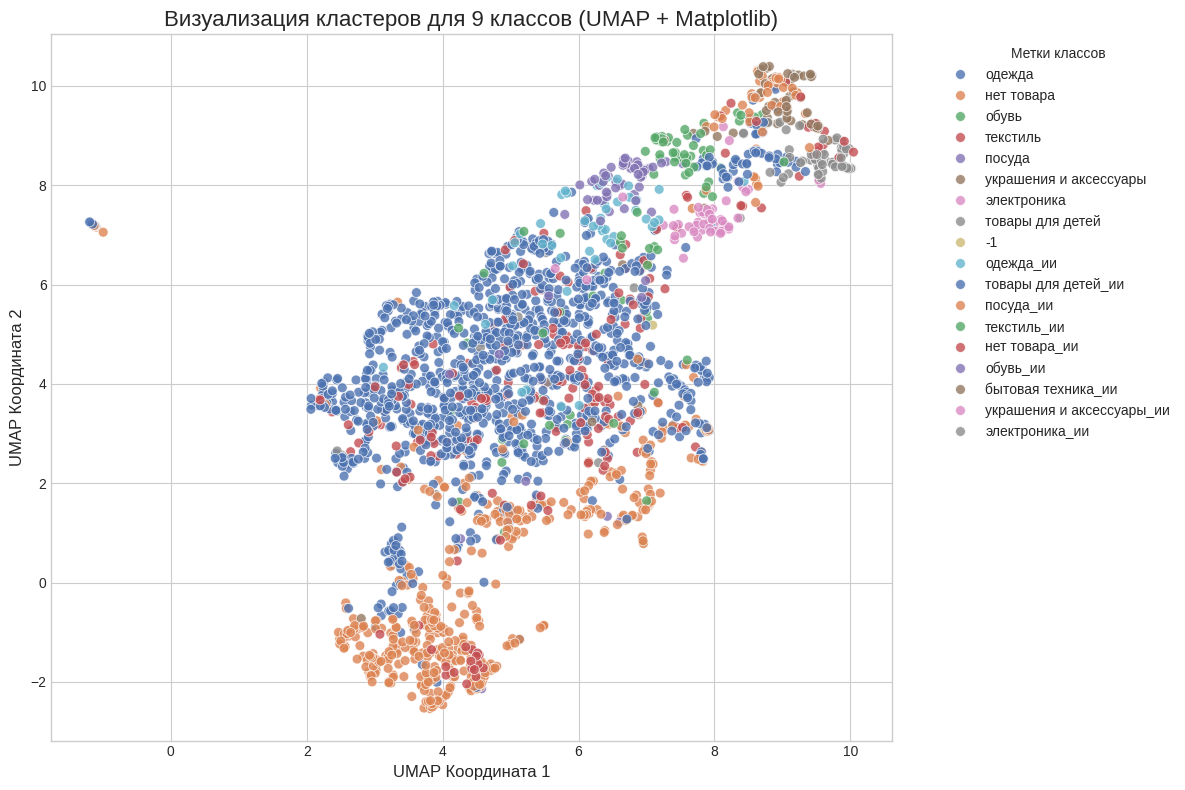

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Создаем статичный график (Matplotlib)...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='umap_x',
    y='umap_y',
    hue='label',
    palette='deep',
    s=50,
    alpha=0.8
)
plt.title('Визуализация кластеров для 9 классов (UMAP + Matplotlib)', fontsize=16)
plt.xlabel("UMAP Координата 1", fontsize=12)
plt.ylabel("UMAP Координата 2", fontsize=12)
plt.legend(title='Метки классов', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('all_data1.pdf', dpi=300)
plt.show()

Отчетливо можем видеть, что в целом сгенерированные данные близки к исходным - что есть хорошо. Проверим что будет, если оставить из исходных данных только одежду и нет товара (наиболее надежные категории)

In [52]:
# фактически полная копипаста, только обработка чуть другая

df = data_raw.copy(deep=True)
df = pd.concat([df[df["category"] == "одежда"], df[df["category"] == "нет товара"]])
df_renamed = df.rename(columns={'category': 'label', 'original_text': 'text'})
df_synth = synthetic_reviews.copy(deep=True)
df_synth_renamed = df_synth.rename(columns={'category': 'label', 'generated_text': 'text'})
df = pd.concat([df_renamed[['text', 'label']], df_synth_renamed[['text', 'label']]])


# Выбор модели и устройства
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'sberbank-ai/sbert_large_nlu_ru'
embedding_model = SentenceTransformer(model_name, device=device)
print(f"Используемое устройство: {device}. Модель '{model_name}' загружена.")

# Вычисление эмбеддингов
texts_to_embed = df['text'].tolist()
with torch.no_grad():
    embeddings = embedding_model.encode(texts_to_embed, show_progress_bar=True, convert_to_tensor=True).cpu().numpy()
print(f"Эмбеддинги вычислены. Размерность: {embeddings.shape}")


# Снижение размерности с помощью UMAP
print("Снижаем размерность с помощью UMAP...")
# Для большего числа классов можно немного увеличить n_neighbors, чтобы лучше видеть глобальную структуру
reducer = umap.UMAP(n_neighbors=8, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
umap_data = reducer.fit_transform(embeddings)



                                                  text          label
515  сапоги выглядели красиво, но внутри очень силь...       обувь_ии
516  маленький такой предмет, но очень полезный. по...  нет товара_ии
517  мужу подарил эти лоферсы, он ими доволен – всё...       обувь_ии
518  покупала этот свитер осенью — казался мягким, ...      одежда_ии
519  ваза из стекла. смотрится хорошо, но хрупкая. ...      посуда_ии
------------------------------
Используемое устройство: cuda. Модель 'sberbank-ai/sbert_large_nlu_ru' загружена.
------------------------------
Начинаем вычисление эмбеддингов...


Batches:   0%|          | 0/67 [00:00<?, ?it/s]

Эмбеддинги вычислены. Размерность: (2122, 1024)
------------------------------
Снижаем размерность с помощью UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Снижение размерности завершено.
------------------------------


In [53]:
# Визуализация
df['umap_x'] = umap_data[:, 0]
df['umap_y'] = umap_data[:, 1]

print("Создаем интерактивный график...")
fig = px.scatter(
    df,
    x='umap_x',
    y='umap_y',
    color='label',
    hover_name='label',
    hover_data={'umap_x': False, 'umap_y': False, 'text': True},
    title='Визуализация кластеров для 9 классов (UMAP + Plotly)',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    template='plotly_white'
)

fig.update_traces(marker=dict(size=8, opacity=0.8))
fig.update_layout(
    legend_title_text='Метки классов',
    xaxis_title="UMAP Координата 1",
    yaxis_title="UMAP Координата 2"
)

Создаем интерактивный график...


In [54]:
fig.show()

Создаем статичный график (Matplotlib)...


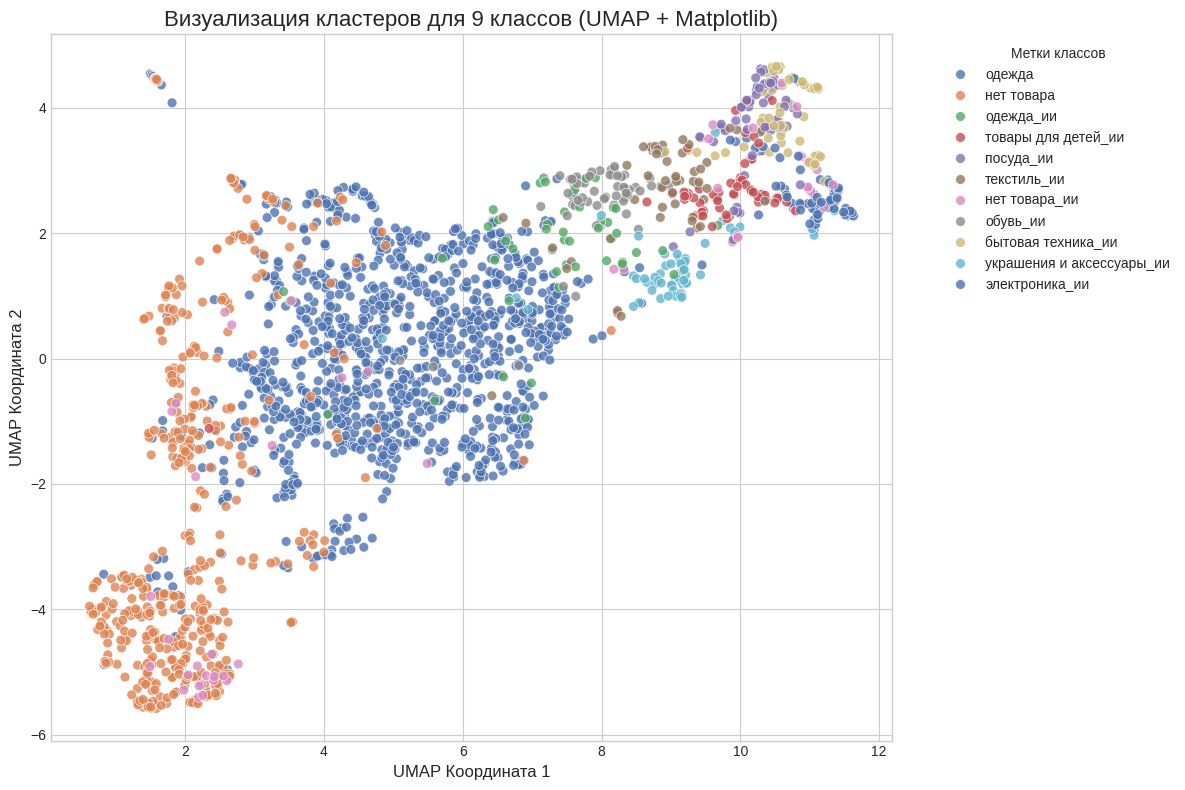

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Создаем статичный график (Matplotlib)...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='umap_x',
    y='umap_y',
    hue='label',
    palette='deep',
    s=50,
    alpha=0.8
)
plt.title('Визуализация кластеров для 9 классов (UMAP + Matplotlib)', fontsize=16)
plt.xlabel("UMAP Координата 1", fontsize=12)
plt.ylabel("UMAP Координата 2", fontsize=12)
plt.legend(title='Метки классов', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('almost_all_data1.pdf', dpi=300)
plt.show()

По анализу можем видеть, что синтетическские отзывы в целом получились. Однако, можем видеть что скорее всего мы получили некоторый bias - отзывы синтетические близки друг к другу, но несколько отделены от остальных данных - что конечно не есть хорошо. Однако, это лучшее что можно получить.